In [ ]:
# default_exp classification.core

<IPython.core.display.Javascript object>

In [ ]:
# hide
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [ ]:
# hide
import warnings

from nbdev.export import *
from nbdev.showdoc import *
from timm.utils import *

warnings.filterwarnings("ignore")

setup_default_logging()

<IPython.core.display.Javascript object>

# Classification Common
> Basic image/data opening/processing/loading functionality

In [ ]:
# export
import logging
import os
from collections import namedtuple
from typing import *

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as T
from fastcore.all import *
from PIL import Image
from timm.data.constants import *
from timm.data.parsers.parser import Parser
from timm.data.parsers.parser_image_folder import ParserImageFolder

from gale.utils.display import show_image, show_images

_logging = logging.getLogger(__name__)

<IPython.core.display.Javascript object>

In [ ]:
# hide
from fastcore.test import *

_IMAGE = "images/puppy.jpg"

<IPython.core.display.Javascript object>

## Helper Functions

In [ ]:
# export
def pil_loader(path: str) -> Image.Image:
    """
    Loads in a Image using PIL
    """
    im = Image.open(path).convert("RGB")
    return im

<IPython.core.display.Javascript object>

PIL library loads an Image from a path and returns the Image in `PIL.Image.Image` format ...

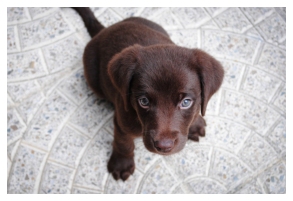

<IPython.core.display.Javascript object>

In [ ]:
im = pil_loader(_IMAGE)
show_image(im)

assert isinstance(im, Image.Image)

In [ ]:
# export
def cv2_loader(path: str) -> np.ndarray:
    """
    Loads in a Image using cv2
    """
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

<IPython.core.display.Javascript object>

Contrary to PIL, `cv2` loads and returns the Image in `np.ndarray` ...

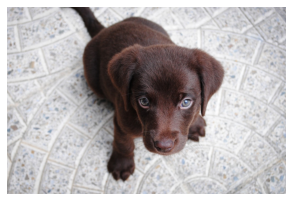

<IPython.core.display.Javascript object>

In [ ]:
im = cv2_loader(_IMAGE)
show_image(im)

assert isinstance(im, np.ndarray)

In [ ]:
# export
@typedispatch
def convert_image(image: Image.Image):
    return np.array(image)

<IPython.core.display.Javascript object>

In [ ]:
# export
@typedispatch
def convert_image(image: np.ndarray):
    return Image.fromarray(image)

<IPython.core.display.Javascript object>

In [ ]:
# export
@typedispatch
def load_and_apply_image_transforms(path: str, transforms: A.Compose):
    image = cv2_loader(path)
    aug_image = transforms(image=image)
    return aug_image["image"]

<IPython.core.display.Javascript object>

In [ ]:
# export
@typedispatch
def load_and_apply_image_transforms(path: str, transforms: T.Compose):
    image = pil_loader(path)
    aug_image = transforms(image)
    return aug_image

<IPython.core.display.Javascript object>

In [ ]:
# export
@typedispatch
def apply_transforms(im: Image.Image, transform: T.Compose):
    return transform(im)

<IPython.core.display.Javascript object>

In [ ]:
# export
@typedispatch
def apply_transforms(im: Image.Image, transform: A.Compose):
    image = np.array(im)
    return transform(image=image)["image"]

<IPython.core.display.Javascript object>

In [ ]:
# export
def denormalize(x: torch.Tensor, mean: torch.FloatTensor, std: torch.FloatTensor):
    "Denormalize `x` with `mean` and `std`."
    return x.cpu().float() * std[..., None, None] + mean[..., None, None]

<IPython.core.display.Javascript object>

In [ ]:
# export
@use_kwargs_dict(
    keep=True,
    figsize=None,
    imsize=3,
    suptitle=None,
)
def show_image_batch(
    batch: Tuple[torch.Tensor],
    n: int = 8,
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    nrows=2,
    ncols=4,
    **kwargs
):
    "Displays an image batch after applying `denormalize`"
    images, labels = batch
    images, labels = images[:n], labels[:n]
    if not isinstance(mean, torch.Tensor):
        mean = torch.Tensor(mean).float()
    if not isinstance(std, torch.Tensor):
        std = torch.Tensor(std).float()

    images = denormalize(images, mean, std)
    images = images.clip(0, 1)
    labels = [x.cpu().numpy().item() for x in labels]
    show_images(ims=images, titles=labels, nrows=nrows, ncols=ncols, **kwargs)

<IPython.core.display.Javascript object>

## DatasetDict-

In [ ]:
# export
class DatasetDict(namedtuple("dataset_dict", ["file_name", "target"])):
    """
    A simple structure that contains the path to the Images and
    Interger target of the Images.
    """

    def __new__(cls, file_name: str, target: int):
        return super().__new__(cls, file_name, target)

<IPython.core.display.Javascript object>

## ClassificationMapper-

In [ ]:
# export
class ClassificationMapper(DisplayedTransform):
    decodes = noop
    """
    A callable which takes in a dataset and map it into a format used by the model.
    This mapper takes in a Dict/str as input . The key "file_name" must contain the
    path to the Image to be loaded and key "target" must contain the integer target.

    The callable currently does the following:
    1. Reads in the image from `file_name`.
    2. Applies transformations to the Images
    3. Converts dataset to return `torch.Tensor` Images & `torch.long` targets
    
    You can also optionally pass in `xtras` these which must be a callable functions. This function
    is applied after converting the images to to tensors. Helpfull for applying trasnformations like
    RandomErasing which requires the inputs to be tensors.
    """

    def __init__(
        self,
        augmentations: Optional[Union[T.Compose, A.Compose]] = None,
        mean: Sequence[float] = IMAGENET_DEFAULT_MEAN,
        std: Sequence[float] = IMAGENET_DEFAULT_STD,
        xtras: Optional[Callable] = noop,
    ):
        """
        Arguments:
        1. `augmentations`: a list of augmentations or deterministic transforms to apply
        2. `mean`, `std`: list or tuple with #channels element, representing the per-channel mean and
        std to be used to normalize the input image. Note: These should be normalized values.
        4. `xtras`: A callable funtion applied after images are normalized and converted to tensors.
        """
        super().__init__()
        store_attr()

        # fmt: off
        self.normalize = T.Compose([
            T.ToTensor(),
            T.Normalize(torch.tensor(self.mean), torch.tensor(self.std)),
        ])
        # fmt: on

    def encodes(self, dataset_dict: DatasetDict):
        """
        For normal use-cases
        """
        # fmt: off
        image = load_and_apply_image_transforms(dataset_dict.file_name, self.augmentations)
        # fmt: on
        image = self.normalize(image)
        image = self.xtras(image)

        assert isinstance(image, torch.Tensor)

        target = dataset_dict.target
        target = torch.tensor(target, dtype=torch.long)
        return image, target

    def encodes(self, torchvision_instance: Tuple):
        """
        For torhcvision instances
        """
        image, target = torchvision_instance
        image = apply_transforms(image, self.augmentations)
        image = self.normalize(image)
        image = self.xtras(image)

        assert isinstance(image, torch.Tensor)

        target = torch.tensor(target, dtype=torch.long)
        return image, target

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationMapper)

<h2 id="ClassificationMapper" class="doc_header"><code>class</code> <code>ClassificationMapper</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ClassificationMapper</code>(**`augmentations`**:`Union`\[`Compose`, `Compose`, `NoneType`\]=*`None`*, **`mean`**:`Sequence`\[`float`\]=*`(0.485, 0.456, 0.406)`*, **`std`**:`Sequence`\[`float`\]=*`(0.229, 0.224, 0.225)`*, **`xtras`**:`Optional`\[`Callable`\]=*`noop`*) :: `DisplayedTransform`

A transform with a `__repr__` that shows its attrs

<IPython.core.display.Javascript object>

In [ ]:
augs = [T.RandomRotation(90), T.RandomHorizontalFlip(1.0), T.ColorJitter(0.4, 0.4, 0.4)]
augs = T.Compose(augs)

mapper = ClassificationMapper(augmentations=augs)
mapper

ClassificationMapper -- {'augmentations': Compose(
    RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=1.0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
), 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'xtras': <function noop at 0x7fc56c767b70>}:
encodes: (DatasetDict,object) -> encodes
(Tuple,object) -> encodes
decodes: (object,object) -> noop

<IPython.core.display.Javascript object>

For training datasets `ClassificationMapper` takes in a `DatasetDict` which contains the keys `file_name`, `targets`; these corresponds to the file path of the Image and the Interger target label for the Image repectively ...

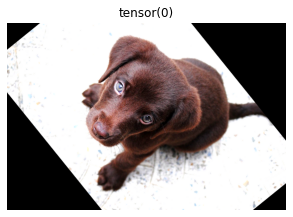

<IPython.core.display.Javascript object>

In [ ]:
datas = DatasetDict(file_name=_IMAGE, target=0)
im, targ = mapper.encodes(datas)

# de-normalize image
im = im.permute(1, 2, 0) * torch.tensor(mapper.std) + torch.tensor(mapper.mean)
show_images([im], titles=[targ], imsize=5)

`ClassificationMapper` with torchvision default datasets ...

Using downloaded and verified file: /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip
Extracting /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip to /Users/ayushman/Desktop/gale/nbs/data


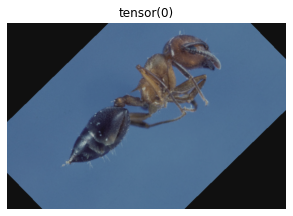

<IPython.core.display.Javascript object>

In [ ]:
import torchvision
from gale.collections.download import download_and_extract_archive
from nbdev.export import Config
from fastcore.all import Path

URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_path = Path(Config().path("nbs_path")) / "data"

# download a toy dataset
download_and_extract_archive(url=URL, download_root=data_path, extract_root=data_path)

# create torchvision dataset instance
path = data_path / "hymenoptera_data"
ds = torchvision.datasets.ImageFolder(root=path / "train")
im, targ = mapper.encodes(ds[0])

# de-normalize image
im = im.permute(1, 2, 0) * torch.tensor(mapper.std) + torch.tensor(mapper.mean)
show_images([im], titles=[targ], imsize=5)

> Note: For Image Classification all your augmentations must return `uint8 or PIL images`. Normalization and conversion to tensors are handled independently by the library. `ClassificationMapper` is compatible both with albumentation augmentations and torchvision augmentations.

In [ ]:
# export
class ClassificationDataset(torch.utils.data.Dataset):
    """
    Map a function over the elements returned by a parser

    Arguments :
    1. `mapper`: a callable which maps the element in dataset, typically `ClassificationMapper`.
    2. `parser`: a `Parser` to load in the Images and their corresponding targets.
    """

    def __init__(self, mapper: DisplayedTransform, parser: Parser):
        store_attr("parser, mapper")

    def __len__(self):
        return len(self.parser)

    def __getitem__(self, index):
        dataset_dict = self.parser[index]
        # preprocess and load the data
        return self.mapper.encodes(dataset_dict)

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationDataset)

<h2 id="ClassificationDataset" class="doc_header"><code>class</code> <code>ClassificationDataset</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>ClassificationDataset</code>(**\*`args`**, **\*\*`kwds`**) :: `Dataset`

Map a function over the elements returned by a parser

Arguments :
1. `mapper`: a callable which maps the element in dataset, typically [`ClassificationMapper`](/gale/classification.data.common.html#ClassificationMapper).
2. `parser`: a `Parser` to load in the Images and their corresponding targets.

<IPython.core.display.Javascript object>

## Parsers

In [ ]:
# export
class FolderParser(ParserImageFolder):
    """
    A generic parser which loads data from `root` where samples are arranged in this way:

    ```
    root/class_x/xxx.ext
    root/class_x/xxy.ext
    root/class_x/[...]/xxz.ext

    root/class_y/123.ext
    root/class_y/nsdf3.ext
    root/class_y/[...]/asd932_.ext

    ```
    """

    def __getitem__(self, index):
        path, target = self.samples[index]
        return DatasetDict(file_name=path, target=target)

<IPython.core.display.Javascript object>

In [ ]:
show_doc(FolderParser)

<h2 id="FolderParser" class="doc_header"><code>class</code> <code>FolderParser</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>FolderParser</code>(**`root`**, **`class_map`**=*`''`*) :: `ParserImageFolder`

A generic parser which loads data from `root` where samples are arranged in this way:

```
root/class_x/xxx.ext
root/class_x/xxy.ext
root/class_x/[...]/xxz.ext

root/class_y/123.ext
root/class_y/nsdf3.ext
root/class_y/[...]/asd932_.ext

```

<IPython.core.display.Javascript object>

Arguments to `FolderParser`:
1. `root`: Root directory path.
2. `class_map`: Path to a `.txt` file which contains the class mapping

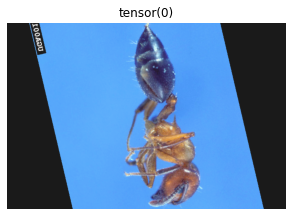

<IPython.core.display.Javascript object>

In [ ]:
parser = FolderParser(root=path / "train")
img, targ = mapper.encodes(parser[0])
img = img.permute(1, 2, 0) * torch.tensor(mapper.std) + torch.tensor(mapper.mean)
show_images([img], titles=[targ], imsize=5)

In [ ]:
# export
class PandasParser(Parser):
    """
    A generic parser which parser data from a pandas dataframe.

    Arguments:

    1. `df`: a pandas dataframe
    2. `path_columne`: name of the column where the Images are stored.
    3. `label_column`: name of the column where the Image targets are stored.
    """

    def __init__(self, df: pd.DataFrame, path_column: str, label_column: str):
        self.df = df
        imgs = self.df[path_column]
        labels = self.df[label_column]
        self.samples = [(i, t) for i, t in zip(imgs, labels)]

    def __getitem__(self, index):
        path, target = self.samples[index]
        return DatasetDict(file_name=str(path), target=target)

    def __len__(self):
        return len(self.samples)

    def _filename(self, index):
        return self.samples[index][0]

    def filename(self, index):
        return self._filename(index)

    def filenames(self):
        return [self._filename(index) for index in range(len(self))]

<IPython.core.display.Javascript object>

In [ ]:
show_doc(PandasParser)

<h2 id="PandasParser" class="doc_header"><code>class</code> <code>PandasParser</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>PandasParser</code>(**`df`**:`DataFrame`, **`path_column`**:`str`, **`label_column`**:`str`) :: `Parser`

A generic parser which parser data from a pandas dataframe.

Arguments:

1. `df`: a pandas dataframe
2. `path_columne`: name of the column where the Images are stored.
3. `label_column`: name of the column where the Image targets are stored.

<IPython.core.display.Javascript object>

In [ ]:
from gale.collections.pandas import folder2df, dataframe_labels_2_int

df = folder2df(path / "train")
df, class_map = dataframe_labels_2_int(df, label_column="target", return_labelling=True)
df.head()

Found 244 files belonging to 2 classes.


,image_id,target
0,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg,1
1,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg,1
2,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg,1
3,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg,1
4,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg,1


<IPython.core.display.Javascript object>

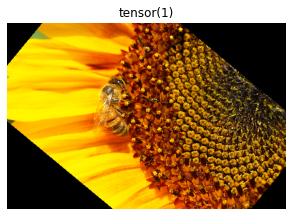

<IPython.core.display.Javascript object>

In [ ]:
parser = PandasParser(df, path_column="image_id", label_column="target")
img, targ = mapper.encodes(parser[0])
img = img.permute(1, 2, 0) * torch.tensor(mapper.std) + torch.tensor(mapper.mean)
show_images([img], titles=[targ], imsize=5)

In [ ]:
# export
class CSVParser(PandasParser):
    """
    Parser for csv files. Parser first loads in csv as a pandas dataframe
    and rest functionality is same as `PandasParser`
    """

    @delegates(pd.read_csv)
    def __init__(self, path: str, path_column: str, label_column: str, **kwargs):
        """
        Arguments:

        1. `path`: path to a csv file
        2. `path_columne`: name of the column where the Images are stored.
        3. `label_column`: name of the column where the Image targets are stored.
        """
        self.df = pd.read_csv(path, **kwargs)
        imgs = self.df[path_column]
        labels = self.df[label_column]
        self.samples = [(i, t) for i, t in zip(imgs, labels)]

<IPython.core.display.Javascript object>

In [ ]:
show_doc(CSVParser)

<h2 id="CSVParser" class="doc_header"><code>class</code> <code>CSVParser</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>CSVParser</code>(**`path`**:`str`, **`path_column`**:`str`, **`label_column`**:`str`, **`sep`**=*`','`*, **`delimiter`**=*`None`*, **`header`**=*`'infer'`*, **`names`**=*`None`*, **`index_col`**=*`None`*, **`usecols`**=*`None`*, **`squeeze`**=*`False`*, **`prefix`**=*`None`*, **`mangle_dupe_cols`**=*`True`*, **`dtype`**=*`None`*, **`engine`**=*`None`*, **`converters`**=*`None`*, **`true_values`**=*`None`*, **`false_values`**=*`None`*, **`skipinitialspace`**=*`False`*, **`skiprows`**=*`None`*, **`skipfooter`**=*`0`*, **`nrows`**=*`None`*, **`na_values`**=*`None`*, **`keep_default_na`**=*`True`*, **`na_filter`**=*`True`*, **`verbose`**=*`False`*, **`skip_blank_lines`**=*`True`*, **`parse_dates`**=*`False`*, **`infer_datetime_format`**=*`False`*, **`keep_date_col`**=*`False`*, **`date_parser`**=*`None`*, **`dayfirst`**=*`False`*, **`cache_dates`**=*`True`*, **`iterator`**=*`False`*, **`chunksize`**=*`None`*, **`compression`**=*`'infer'`*, **`thousands`**=*`None`*, **`decimal`**:`str`=*`'.'`*, **`lineterminator`**=*`None`*, **`quotechar`**=*`'"'`*, **`quoting`**=*`0`*, **`doublequote`**=*`True`*, **`escapechar`**=*`None`*, **`comment`**=*`None`*, **`encoding`**=*`None`*, **`dialect`**=*`None`*, **`error_bad_lines`**=*`True`*, **`warn_bad_lines`**=*`True`*, **`delim_whitespace`**=*`False`*, **`low_memory`**=*`True`*, **`memory_map`**=*`False`*, **`float_precision`**=*`None`*) :: [`PandasParser`](/gale/classification.data.common.html#PandasParser)

Parser for csv files. Parser first loads in csv as a pandas dataframe
and rest functionality is same as [`PandasParser`](/gale/classification.data.common.html#PandasParser)

<IPython.core.display.Javascript object>

## End to End Example

To create a Image classification dataset for Gale we need to do the following -

In [ ]:
# first download the datset
URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_path = Path(Config().path("nbs_path")) / "data"

# download a toy dataset
download_and_extract_archive(url=URL, download_root=data_path, extract_root=data_path)

# take a peek at the structure of the dataset
path = data_path / "hymenoptera_data"
path.ls(), (path / "train").ls()

Using downloaded and verified file: /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip
Extracting /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip to /Users/ayushman/Desktop/gale/nbs/data


((#2) [Path('/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train'),Path('/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/val')],
 (#2) [Path('/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees'),Path('/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/ants')])

<IPython.core.display.Javascript object>

Data is stored in folders named after the classes. Also the data is divided into 2 subsets, we will only work with the `train` subset of the current dataset. We first initialize our parser :

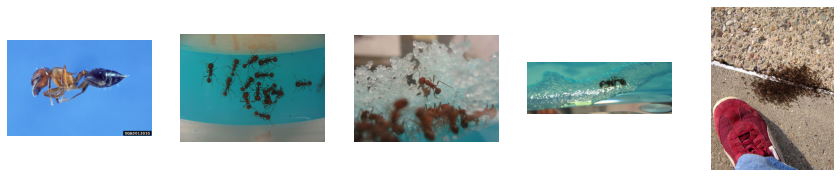

<IPython.core.display.Javascript object>

In [ ]:
parser = FolderParser(root=path / "train")

ims = []
targs = []

# Let's check some samples from our parser
for i in range(5):
    img = parser[i].file_name
    targ = parser[i].target
    ims.append(Image.open(img))
    targs.append(targ)


show_images(ims)

Now that the Parser is corectly loading the Images, to get our data in Dataset's and DataLoader's we need to first create a maper for `ClassificationDataset`.
The mapper will contain all the image augmentations and preprocessing necessary to prepare our data. While applying augmentations we do not need to normalize or convert our data to `Tensors`, this is automatically done by the `Mapper` :

In [ ]:
# fmt: off
# you can add even more facncy augmentations here
augs = A.Compose([A.Resize(128,128,p=1.0),A.HueSaturationValue(p=1.0)])
# also supports torchvision augmentations
# augs  = T.Compose([T.Resize((128,128)), T.ColorJitter(0.3, 0.3, 0.3)])

mapper = ClassificationMapper(augmentations=augs)
dset = ClassificationDataset(mapper=mapper, parser=parser)

# Let's creat the dataloader
loader = torch.utils.data.DataLoader(dset, batch_size=8, shuffle=True)

<IPython.core.display.Javascript object>

View images from the `DataLoader` for sanity check -

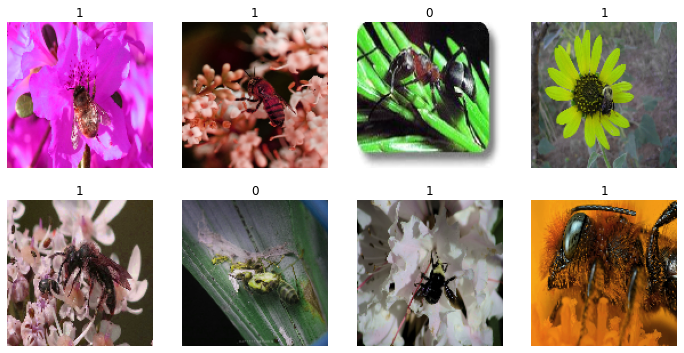

<IPython.core.display.Javascript object>

In [ ]:
samples = next(iter(loader))
show_image_batch(samples)

## Export-

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script("05_classification.core.ipynb")

Converted 05_classification.core.ipynb.


<IPython.core.display.Javascript object>